In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
import requests
import time
from typing import Dict, List, Optional
from geckoTerminalClient import GeckoTerminalClient, YieldSamuraiClient

class LPProfitabilityTool:
    def __init__(
        self, network: str, pool_address: str, fee_tier: float, base_token: str,
        yieldsamurai_api_key: Optional[str] = None
    ):
        self.gecko_client = GeckoTerminalClient()
        self.yieldsamurai_client = YieldSamuraiClient(api_key=yieldsamurai_api_key)
        self.network = network
        self.pool_address = pool_address
        self.fee_tier = fee_tier
        self.base_token = base_token
        self.deribit = ccxt.deribit()
        try:
            plt.style.use('seaborn-v0_8')
        except:
            plt.style.use('ggplot')
        sns.set_palette("viridis")

    def fetch_and_save_data(self, timeframe: str = "hour", limit: int = 168) -> pd.DataFrame:
        """Fetch data from both clients and save to CSVs (7 days max)."""
        # Fetch and save GeckoTerminal OHLCV
        ohlcv = self.gecko_client.fetch_pool_ohlcv(
            self.network, self.pool_address, timeframe, limit=limit
        )
        if not ohlcv:
            print("Failed to fetch OHLCV data")
            return pd.DataFrame()

        ohlcv_df = pd.DataFrame(ohlcv)
        ohlcv_csv = f"gecko_ohlcv_{self.network}_{self.pool_address[:6]}.csv"
        ohlcv_df.to_csv(ohlcv_csv, index=False)
        print(f"GeckoTerminal OHLCV saved to {ohlcv_csv}")

        # Fetch and save GeckoTerminal pool metrics
        metrics = self.gecko_client.fetch_pool_metrics(self.network, self.pool_address)
        if metrics:
            metrics_df = pd.DataFrame([metrics])
            metrics_csv = f"gecko_metrics_{self.network}_{self.pool_address[:6]}.csv"
            metrics_df.to_csv(metrics_csv, index=False)
            print(f"GeckoTerminal metrics saved to {metrics_csv}")
            current_tvl = metrics.get("tvl_usd", 0)
        else:
            current_tvl = 0

        # Prepare OHLCV DataFrame
        df = ohlcv_df.copy()
        df["tick"] = np.floor(np.log(df["close"] / df["close"].iloc[0]) / np.log(1.0001))

        # Fetch and save YieldSamurai TVL
        tvl = self.yieldsamurai_client.fetch_tvl(self.network, self.pool_address, days=7)
        if tvl:
            tvl_df = pd.DataFrame(tvl)
            # Merge OHLCV and TVL
            df = pd.merge_asof(
                df.sort_values("datetime"),
                tvl_df[["datetime", "tvl_usd"]].sort_values("datetime"),
                on="datetime",
                tolerance=pd.Timedelta(minutes=30),
                direction="nearest"
            )
            df["tvl_usd"] = df["tvl_usd"].ffill()
        else:
            print("Using estimated TVL from current pool metrics")
            df["tvl_usd"] = current_tvl * (df["close"] / df["close"].iloc[-1])

        if df["tvl_usd"].isna().any():
            print("Warning: Some TVL values missing; using last known TVL")
            df["tvl_usd"] = df["tvl_usd"].fillna(current_tvl)

        return df.sort_values("timestamp")

    def calculate_il(self, start_price: float, end_price: float, investment: float) -> float:
        """Calculate impermanent loss in USD."""
        price_ratio = end_price / start_price
        il_pct = 2 * np.sqrt(price_ratio) / (1 + np.sqrt(price_ratio)) - 1
        return abs(il_pct * investment)

    def estimate_fees(self, volume: float, range_width: float, tvl: float) -> float:
        """Estimate fees using TVL-based LP share."""
        if tvl <= 0:
            print("Invalid TVL; using fixed share fallback")
            lp_share = 0.01
        else:
            lp_share = min(self.initial_investment / tvl, 1.0)
        in_range_volume = volume * (1 / range_width)
        return in_range_volume * self.fee_tier * lp_share

    def simulate_profitability(self, initial_investment: float, range_width: float) -> Dict:
        """Simulate LP profitability."""
        self.initial_investment = initial_investment
        df = self.fetch_and_save_data()
        if df.empty:
            return {"pnl_usd": 0, "pnl_base_token": 0, "il": 0}

        fees = sum(self.estimate_fees(row["volume"], range_width, row["tvl_usd"])
                   for _, row in df.iterrows())
        il = self.calculate_il(df["close"].iloc[0], df["close"].iloc[-1], initial_investment)
        gas_fees = 0.02 * initial_investment
        token_gain = (df["close"].iloc[-1] - df["close"].iloc[0]) / df["close"].iloc[0] * initial_investment * 0.5

        pnl_usd = fees - il - gas_fees + token_gain
        pnl_base_token = pnl_usd / df["close"].iloc[-1]
        return {"pnl_usd": pnl_usd, "pnl_base_token": pnl_base_token, "il": il}

    def simulate_rebalancing(
        self, initial_investment: float, range_width: float, price_threshold: float = 0.05
    ) -> Dict:
        """Simulate profitability with rebalancing."""
        self.initial_investment = initial_investment
        df = self.fetch_and_save_data()
        if df.empty:
            return {"pnl_usd": 0, "pnl_base_token": 0, "il": 0}

        current_capital = initial_investment
        fees, il_total, gas_fees = 0, 0, 0
        last_price = df["close"].iloc[0]

        for i in range(1, len(df)):
            row = df.iloc[i]
            price_change = abs((row["close"] - last_price) / last_price)
            if price_change >= price_threshold:
                fees += self.estimate_fees(row["volume"], range_width, row["tvl_usd"])
                il = self.calculate_il(last_price, row["close"], current_capital)
                il_total += il
                gas_fees += 0.005 * initial_investment
                last_price = row["close"]
                current_capital = current_capital + fees - il - gas_fees
            else:
                fees += self.estimate_fees(row["volume"], range_width, row["tvl_usd"])
                il = self.calculate_il(df.iloc[i-1]["close"], row["close"], current_capital)
                il_total += il
                current_capital = current_capital + fees - il

        pnl_usd = current_capital - initial_investment
        pnl_base_token = pnl_usd / df["close"].iloc[-1]
        return {"pnl_usd": pnl_usd, "pnl_base_token": pnl_base_token, "il": il_total}

    def simulate_hedging(self, initial_investment: float, range_width: float) -> Dict:
        """Simulate profitability with futures hedging."""
        self.initial_investment = initial_investment
        df = self.fetch_and_save_data()
        if df.empty:
            return {"pnl_usd": 0, "pnl_base_token": 0, "il": 0, "hedge_pnl": 0}

        current_capital = initial_investment
        fees, il_total, gas_fees, hedge_pnl = 0, 0, 0, 0
        last_price = df["close"].iloc[0]
        position_size = initial_investment * 0.5 / last_price

        futures_data = self.deribit.fetch_ohlcv(
            f"{self.base_token}/USD", timeframe="1h", limit=len(df)
        )
        futures_df = pd.DataFrame(
            futures_data, columns=["timestamp", "open", "high", "low", "close", "volume"]
        )
        futures_df["timestamp"] = futures_df["timestamp"] // 1000

        for i in range(1, len(df)):
            row = df.iloc[i]
            futures_row = futures_df[futures_df["timestamp"] == row["timestamp"]]
            if futures_row.empty:
                continue
            futures_price = futures_row["close"].iloc[0]
            price_change = (row["close"] - last_price) / last_price
            if price_change >= 0.05:
                fees += self.estimate_fees(row["volume"], range_width, row["tvl_usd"])
                il = self.calculate_il(last_price, row["close"], current_capital)
                il_total += il
                gas_fees += 0.005 * initial_investment
                hedge_pnl += -price_change * position_size * futures_price
                last_price = row["close"]
                current_capital = current_capital + fees - il - gas_fees + hedge_pnl
            else:
                fees += self.estimate_fees(row["volume"], range_width, row["tvl_usd"])
                il = self.calculate_il(df.iloc[i-1]["close"], row["close"], current_capital)
                il_total += il
                hedge_pnl += -((futures_price - futures_df["close"].iloc[i-1]) /
                              futures_df["close"].iloc[i-1]) * position_size * futures_price
                current_capital = current_capital + fees - il + hedge_pnl

        pnl_usd = current_capital - initial_investment
        pnl_base_token = pnl_usd / df["close"].iloc[-1]
        return {"pnl_usd": pnl_usd, "pnl_base_token": pnl_base_token, "il": il_total, "hedge_pnl": hedge_pnl}

    def plot_range_width_impact(self, initial_investment: float, range_widths: List[float]):
        """Plot profitability vs. range width."""
        results = [self.simulate_profitability(initial_investment, rw) for rw in range_widths]
        pnls = [r["pnl_usd"] for r in results]
        ils = [r["il"] for r in results]

        plt.figure(figsize=(10, 6))
        plt.plot(range_widths, pnls, label="PnL (USD)", color="#1f77b4")
        plt.plot(range_widths, ils, label="Impermanent Loss (USD)", color="#ff7f0e")
        plt.xlabel("Range Width (% of Current Price)")
        plt.ylabel("USD")
        plt.title("LP Profitability vs. Range Width")
        plt.legend()
        plt.grid(True)
        plt.show()





In [3]:
# Example Usage
tool = LPProfitabilityTool(
    network="ethereum",  # Use 'ethereum' to match YieldSamurai
    pool_address="0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640",  # WETH/USDC
    fee_tier=0.003,
    base_token="ETH"
)
initial_investment = 10000
range_widths = [0.05, 0.1, 0.2, 0.5]

print("Basic Profitability:", tool.simulate_profitability(initial_investment, 0.1))




GeckoTerminal OHLCV saved to gecko_ohlcv_ethereum_0x88e6.csv
Error making request to /networks/ethereum/pools/0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640: 404 Client Error: Not Found for url: https://api.geckoterminal.com/api/v2/networks/ethereum/pools/0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
No data found for pool 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 on ethereum
YieldSamurai request: https://api.yieldsamurai.com/v1/pools/ethereum/0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640/historical with params {'days': 7, 'interval': 'hourly'}
YieldSamurai TVL saved to yieldsamurai_tvl_ethereum_0x88e6.csv
Basic Profitability: {'pnl_usd': np.float64(1170.9606663909926), 'pnl_base_token': np.float64(0.46210335771829003), 'il': np.float64(8.706278266483736)}


Rebalancing Profitability: PnL USD: 16916.87, PnL Base Token: 9.397427, IL: -1770.20
Hedged Profitability: PnL USD: 253708.35, PnL Base Token: 140.936555, IL: -861.33, Hedge PnL: 237650.35


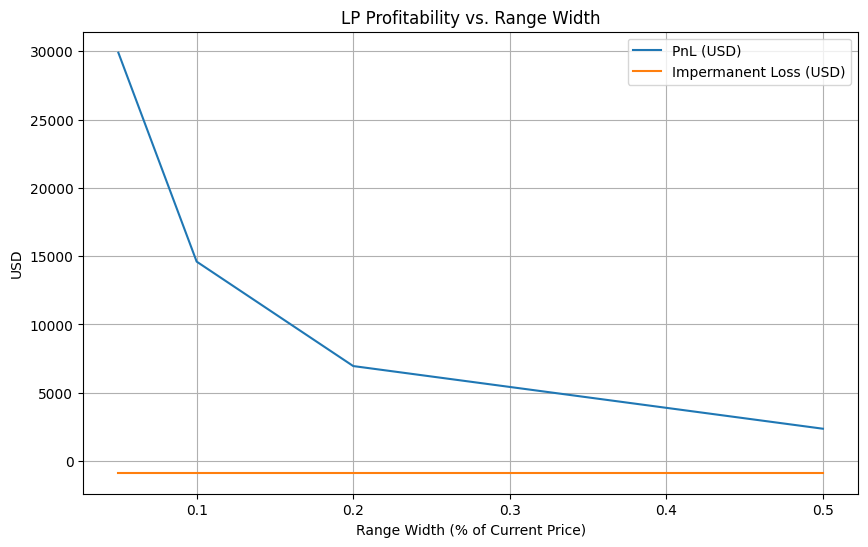

In [ ]:
print("Rebalancing Profitability:", tool.simulate_rebalancing(initial_investment, 0.1))
print("Hedged Profitability:", tool.simulate_hedging(initial_investment, 0.1))
tool.plot_range_width_impact(initial_investment, range_widths)